# 1 . Preparación del entorno

> * Instalamos los recursos necesarios (librerías y paquetes).
* Preparamos nuestro entorno de ejecución definiendo la utilización de GPU.


In [1]:
# Instalamos fastbook
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 6.9MB/s 
     |████████████████████████████████| 204kB 12.8MB/s 
     |████████████████████████████████| 1.2MB 17.7MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
Mounted at /content/gdrive


In [2]:
# Cargamos las librerías 
from fastbook import *
!pip install timm
import timm
import re
import os, os.path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

     |████████████████████████████████| 348kB 8.0MB/s 


# 2 . Preparación de los datos


Descomprimimos el *data set* contenido en un archivo .zip en el directorio que deseamos. 

Posteriormente definimos el `DataBlock` correspondiente con las siguientes características.



*  `valid_pct=0.2` Utilizamos el 20% de los datos como conjunto de test.
*  Utilizamos el propio nombre de la imagen como etiqueta de clasificación.
*  `item_tfms=Resize(224)` fijamos el mismo tamaño para todas las imágenes.
*  `aug_transforms` definimos los parámetros del *data augmentation*.

Por último mostramos un ejemplo de imagenes de estudio con sus respectivas etiquetas y calculamos el número total de imagenes contenidas en nuestro *data set*.

In [3]:
#hide_output
# Accedemos al directorio con los datos
%cd gdrive/MyDrive/Data

# Copiamos los datos en el directorio /content
!cp PBC_dataset_normal_DIB.zip /content

%cd /content
# Descomprimimos el archivo zip con los datos en el directorio /content
!unzip PBC_dataset_normal_DIB.zip 

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_292483.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_935950.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_890863.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_519370.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_215077.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_388154.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_968896.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_34345.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_349907.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_245683.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_785122.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_615525.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_714613.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_904757.jpg  
  inflating: PBC

Renombramos las imagenes en función de los tipos celulares principales de trabajo. 

In [4]:
# Creamos el path a nuestros datos
DIR = "/content/PBC_dataset_normal_DIB"
path_ne = os.path.join(DIR, "neutrophil")
os.remove(os.path.join(path_ne, ".DS_169665.jpg"))

Tamaño original de las imágenes: torch.Size([363, 360, 3])
Tamaño del batch: 64
Número de etiquetas distintas: 8
- basophil
- eosinophil
- erythroblast
- ig
- lymphocyte
- monocyte
- neutrophil
- platelet


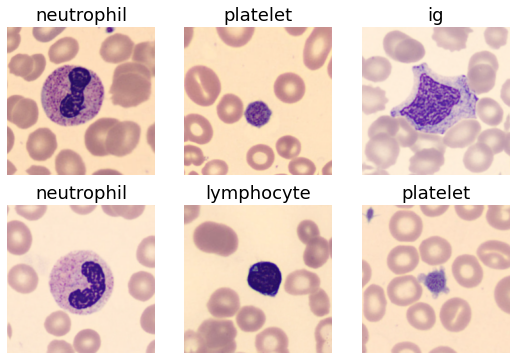

In [5]:
DIR = "/content/PBC_dataset_normal_DIB"
# Obtnemos las dimensiones de nuestras imagenes
t = get_image_files(DIR)
im_t  = tensor(Image.open(t[4000]))
print('Tamaño original de las imágenes:',im_t.shape)

# Generamos el DataBlock de las imagenes

imagenes = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42, valid_pct=0.2),
                 get_y = parent_label,
                 #get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(224),
                 batch_tfms=aug_transforms(min_scale=0.75, size=224))
dls = imagenes.dataloaders(DIR)

#Obtenemos la longitud del batch fijada por defecto
x,y = dls.one_batch()
print('Tamaño del batch:',len(x))
print('Número de etiquetas distintas:', len(dls.vocab))
[print('-',line) for line in dls.vocab]

plt.rcParams.update({'font.size': 15})
dls.show_batch(max_n = 6, nrows=2)
plt.savefig('ejemplo_batch.png')



In [ ]:
#Imágenes por cada clase principal 
n = []
clase = []

for base, dirs, files in os.walk(DIR):
    for dir in dirs: 
      clase.append(dir)
      l = os.listdir(os.path.join(DIR, dir))
      n.append(len(l))

#Creamos el diccionario
diccionario = dict(zip(clase,n))

print('Número total de imágenes',sum(n))

df = pd.DataFrame.from_dict(diccionario, orient='index').reset_index()
df = df.rename(columns={'index':'Clase', 0:'Número de imágenes'})
print(df)


Número total de imágenes 17092
          Clase  Número de imágenes
0      monocyte                1420
1  erythroblast                1551
2      basophil                1218
3    eosinophil                3117
4    lymphocyte                1214
5      platelet                2348
6    neutrophil                3329
7            ig                2895


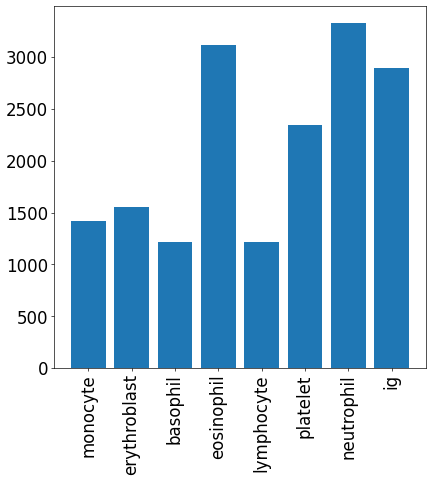

In [ ]:
# Generamos un gráfico de barras a partir de la información anterior
plt.rcParams.update({'font.size': 20})
figure(figsize=(8, 8), dpi=60)
plt.bar(diccionario.keys(), diccionario.values())
plt.xticks(rotation=90, fontsize=20)
plt.savefig('barplot_principales.png')

In [ ]:
#Imágenes por cada subtipo 
lista = []
for base, dirs, files in os.walk(DIR):
    for dir in dirs: 
      for item in os.listdir(os.path.join(DIR, dir)):
        f = item.split('_')
        lista.append(f[0])
     
c = Counter(lista)  

df = pd.DataFrame.from_dict(c, orient='index').reset_index()
df = df.rename(columns={'index':'Clase', 0:'Número de imágenes'})
print(df)

print('Número total de imágenes',len(lista))


         Clase  Número de imágenes
0           MO                1420
1          ERB                1551
2           BA                1218
3           EO                3117
4           LY                1214
5     PLATELET                2348
6          SNE                1646
7          BNE                1633
8   NEUTROPHIL                  50
9          PMY                 592
10          MY                1137
11          IG                 151
12         MMY                1015
Número total de imágenes 17092


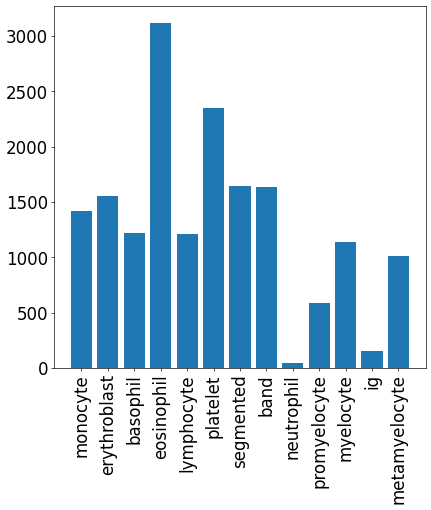

In [ ]:
# Gráfico de barras utilizando subclases 
plt.rcParams.update({'font.size': 20})
figure(figsize=(8, 8), dpi=60)
eti = ['monocyte', 'erythroblast', 'basophil','eosinophil',
       'lymphocyte', 'platelet', 'segmented', 'band', 'neutrophil',
       'promyelocyte', 'myelocyte','ig', 'metamyelocyte']
plt.bar(eti, c.values())
plt.xticks(rotation=90, fontsize=20)
plt.savefig('barplot_subtipos.png')

# 3 . Definimos los modelos

Para el desarrollo de esta implementación utilizaremos la librería `fast.ai` en la que dispone los modelos preentrenados de torchvision de implementaciones de distinto número de capas de ResNet. 

Nos centraremos en las siguientes arquitecturas: 


*   `resnet18`: ResNet de 18 capas
*   `resnet34`: ResNet de 34 capas



## ResNet18

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,accuracy,balanced_accuracy_score,cohen_kappa_score,time
0,0.304858,0.181420,0.059977,0.940023,0.929982,0.929887,02:18
1,0.139491,0.086480,0.028087,0.971913,0.971711,0.967218,02:18
2,0.092884,0.086323,0.028964,0.971036,0.968942,0.966180,02:18


SuggestedLRs(lr_min=2.7542287170945203e-07, lr_steep=1.5848931980144698e-06)

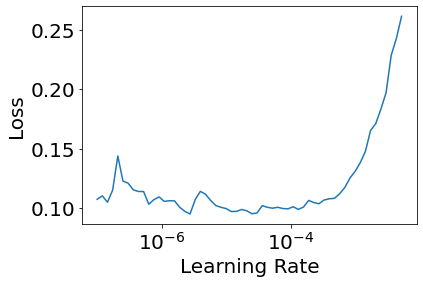

In [ ]:
kappa = CohenKappa()
baccuracy = BalancedAccuracy()
learn = cnn_learner(dls, resnet18, pretrained=True,
                     metrics=[error_rate, accuracy, baccuracy,
                              kappa])
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,accuracy,balanced_accuracy_score,cohen_kappa_score,time
0,0.088207,0.078596,0.025161,0.974839,0.975617,0.970640,03:00
1,0.080957,0.072012,0.023113,0.976887,0.977078,0.973007,02:59
2,0.081143,0.065640,0.020187,0.979813,0.978851,0.976421,02:59
3,0.058778,0.101832,0.031012,0.968988,0.974231,0.963828,02:59
4,0.048117,0.064974,0.019602,0.980398,0.983618,0.977124,02:59
5,0.050706,0.073651,0.023405,0.976595,0.977427,0.972687,02:59
6,0.037226,0.062072,0.018139,0.981861,0.983925,0.978826,02:59
7,0.026287,0.051251,0.015799,0.984201,0.985342,0.981552,02:59
8,0.027735,0.044949,0.014043,0.985957,0.986935,0.983600,02:59
9,0.017176,0.050708,0.016091,0.983909,0.984508,0.981204,02:59


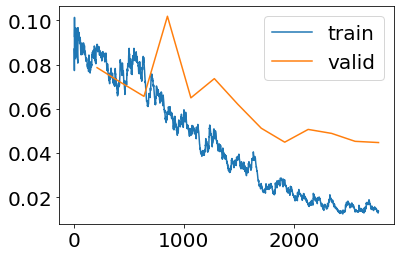

In [ ]:
learn.fit_one_cycle(13, lr_max=slice(1e-5,3e-4))

#Plot train vs. test
learn.recorder.plot_loss()





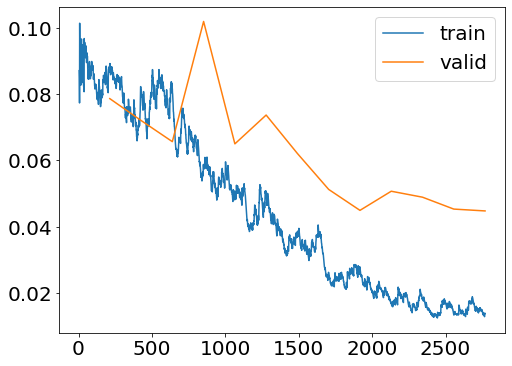

In [ ]:
#Plot train vs. test
plt.figure( figsize=(8, 6))
learn.recorder.plot_loss()
plt.savefig('train_resnet18.png')

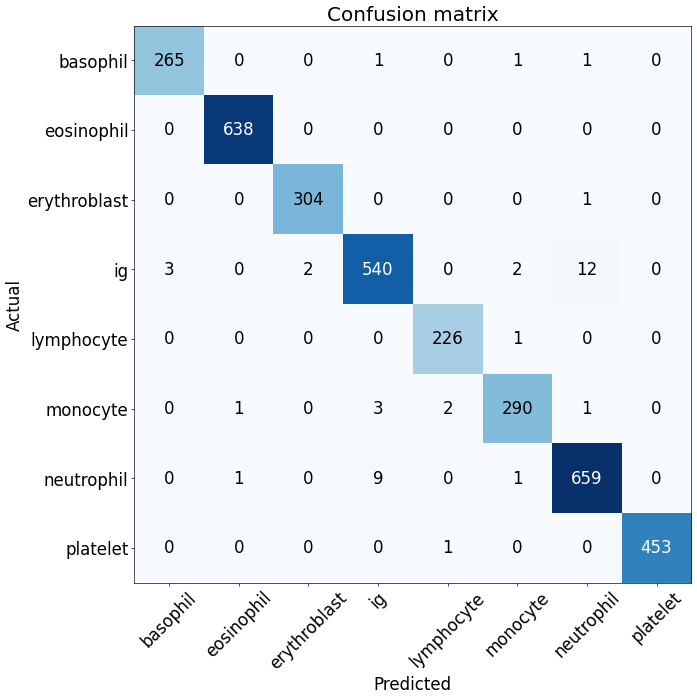

In [ ]:
# Genereamos la matriz de confusión correspondiente
interp = ClassificationInterpretation.from_learner(learn)
plt.rcParams.update({'font.size': 20})
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
plt.xticks(rotation=45, fontsize=20)
plt.savefig('cm_resnet18.png')

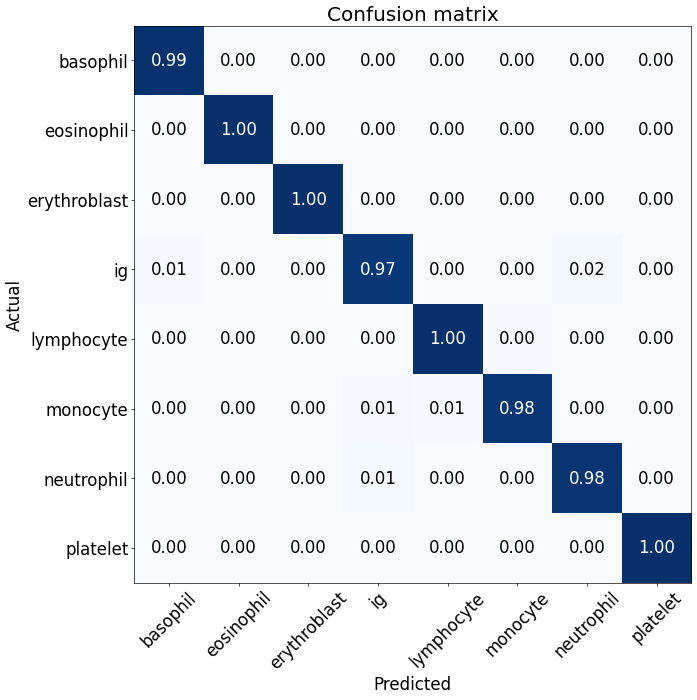

In [ ]:
#Matriz de confusión normalizada
interp = ClassificationInterpretation.from_learner(learn)
plt.rcParams.update({'font.size': 20})
interp.plot_confusion_matrix(figsize=(12,12), dpi=60, normalize =True)
plt.xticks(rotation=45, fontsize=20)
plt.savefig('cmn_resnet18.png')


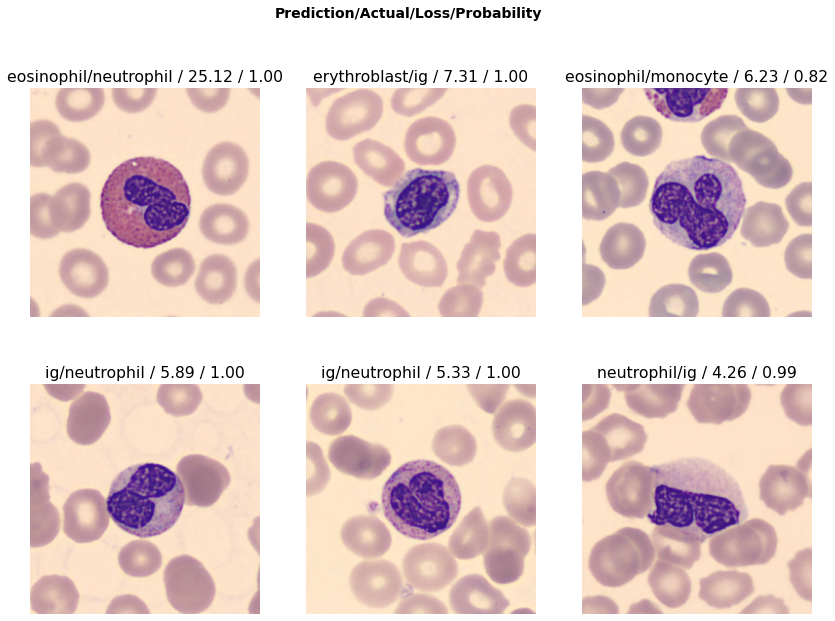

In [ ]:

#Peor clasificados vistos en imagenes
plt.rcParams.update({'font.size': 13})
interp.plot_top_losses(6, nrows=2,figsize=(14,10))

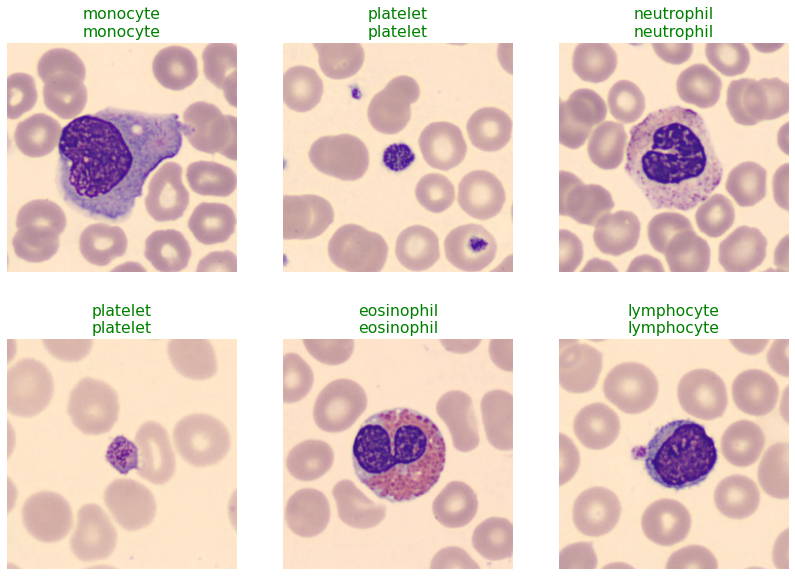

In [ ]:
#Ejemplo clasificación
plt.rcParams.update({'font.size': 13})
learn.show_results(max_n=6, nrows=2, figsize=(14,10))

##ResNet34

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,accuracy,balanced_accuracy_score,cohen_kappa_score,time
0,0.269150,0.148671,0.043300,0.956700,0.955629,0.949455,01:37
1,0.125063,0.080634,0.023405,0.976595,0.975768,0.972662,01:37
2,0.082912,0.074727,0.024576,0.975424,0.976067,0.971291,01:37


SuggestedLRs(lr_min=1.2022644114040304e-06, lr_steep=9.12010818865383e-07)

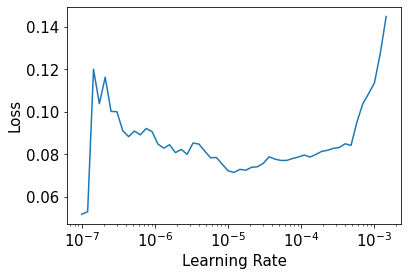

In [7]:
kappa = CohenKappa()
baccuracy = BalancedAccuracy()
learn2 = cnn_learner(dls, resnet34, pretrained=True,
                     metrics=[error_rate, accuracy, baccuracy, kappa])
learn2.fit_one_cycle(3, 3e-3)
learn2.unfreeze()
learn2.lr_find()

epoch,train_loss,valid_loss,error_rate,accuracy,balanced_accuracy_score,cohen_kappa_score,time
0,0.074164,0.066444,0.022528,0.977472,0.978657,0.973692,02:07
1,0.070558,0.073266,0.020772,0.979228,0.978893,0.975734,02:06
2,0.076066,0.074530,0.023991,0.976009,0.973090,0.971966,02:06
3,0.057270,0.077525,0.023698,0.976302,0.978179,0.972326,02:06
4,0.040379,0.087032,0.022820,0.977180,0.980342,0.973354,02:06
5,0.050019,0.095453,0.025746,0.974254,0.978463,0.969953,02:06
6,0.027818,0.057324,0.014921,0.985079,0.986169,0.982570,02:06
7,0.020989,0.058789,0.016384,0.983616,0.982907,0.980865,02:06
8,0.022717,0.058525,0.015799,0.984201,0.984493,0.981542,02:06
9,0.016103,0.062913,0.018724,0.981276,0.981732,0.978129,02:06


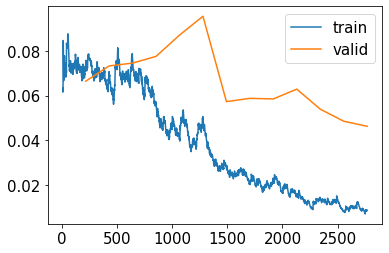

In [8]:
learn2.fit_one_cycle(13, lr_max=slice(1e-5,2e-4))
#Plot train vs. test
learn2.recorder.plot_loss()


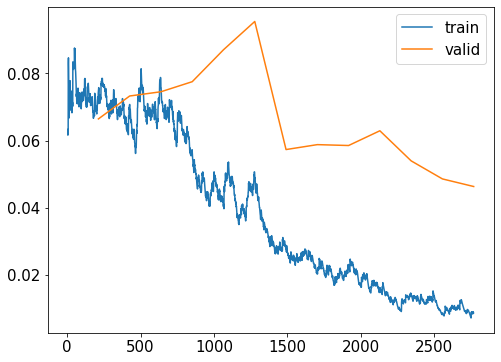

In [9]:
#Plot train vs. test
plt.figure( figsize=(8, 6))
learn2.recorder.plot_loss()
plt.savefig('train_resnet34.png')

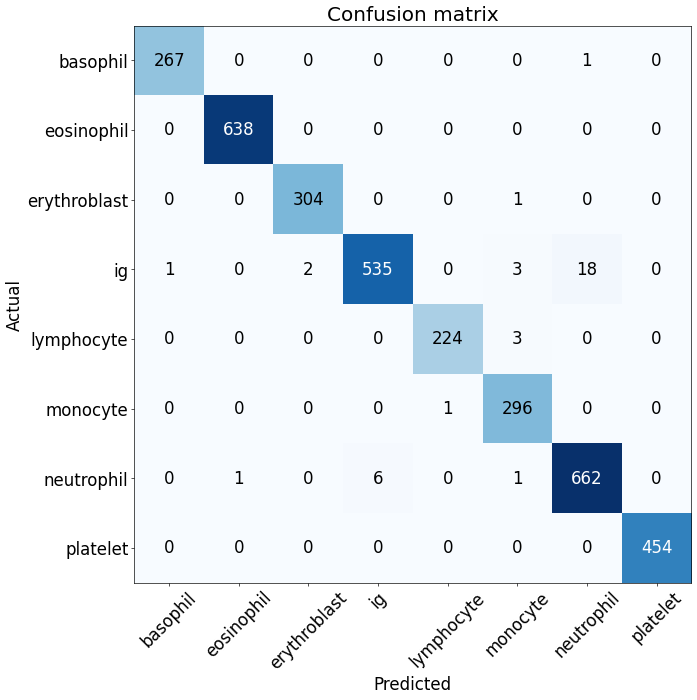

In [10]:
# Genereamos la matriz de confusión correspondiente
interp2 = ClassificationInterpretation.from_learner(learn2)
plt.rcParams.update({'font.size': 20})
interp2.plot_confusion_matrix(figsize=(12,12), dpi=60)
plt.xticks(rotation=45, fontsize=20)
plt.savefig('cm_resnet34.png')

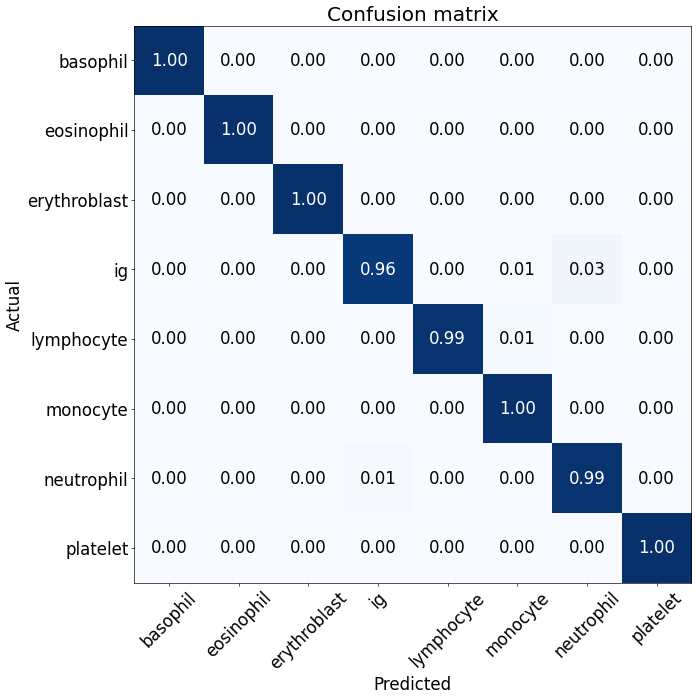

In [11]:
#Matriz de confusión normalizada
plt.rcParams.update({'font.size': 20})
interp2.plot_confusion_matrix(figsize=(12,12), dpi=60, normalize =True)
plt.xticks(rotation=45, fontsize=20)
plt.savefig('cmn_resnet34.png')


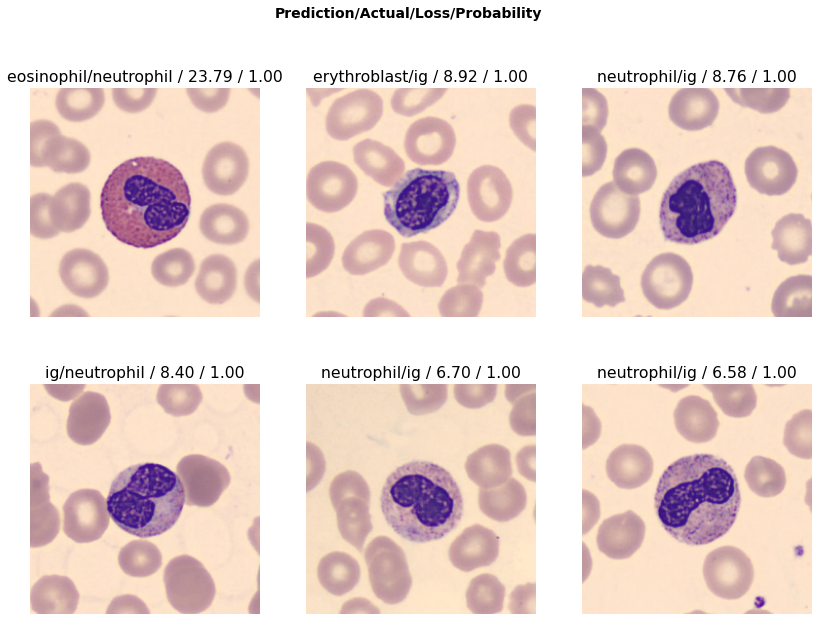

In [12]:
#Peor clasificados vistos en imagenes
plt.rcParams.update({'font.size': 13})
interp2.plot_top_losses(6, nrows=2,figsize=(14,10))

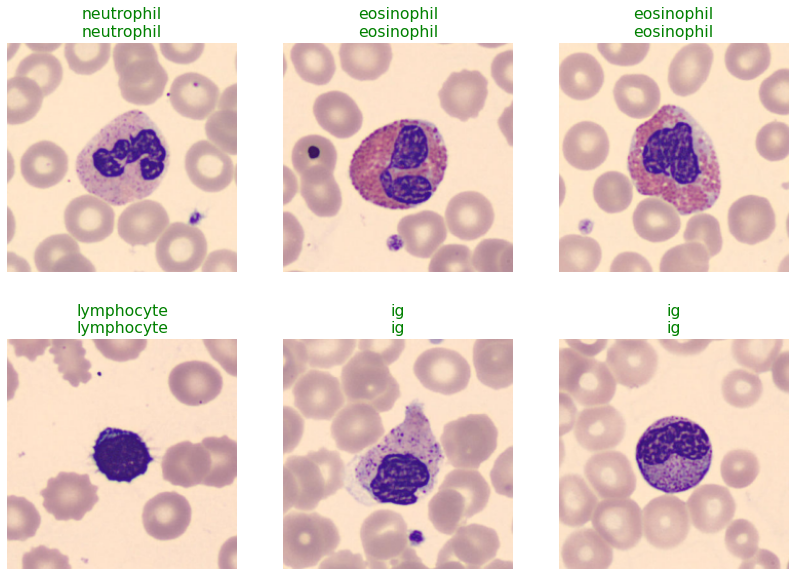

In [13]:
#Ejemplo clasificación
plt.rcParams.update({'font.size': 13})
learn2.show_results(max_n=6, nrows=2, figsize=(14,10))

#4.Creación interfaz gráfica

Creamos una simple interfaz gráfica que nos permita clasificar la imagen que queramos con cualquiera de las dos redes disponibles: 
* ResNet18 
* ResNet34

In [ ]:
#Modelo ResNet18
path  = Path()
!mkdir -p resnet18
learn.path = path/'resnet18'
learn.export()
path_18 = os.path.join(path, 'resnet18')
learn_inf = load_learner(os.path.join(path_18, 'export.pkl'))

In [14]:
#Modelo ResNet34
path  = Path()
!mkdir -p resnet34
learn2.path = path/'resnet34'
learn2.export()
path_34 = os.path.join(path, 'resnet34')
learn_inf2 = load_learner(os.path.join(path_34, 'export.pkl'))


In [ ]:
#Definimos los valores de los elemento que vamos a utilizar
#hide_output

btn_upload = widgets.FileUpload(multiple=False)

out_pl = widgets.Output()

btn_run = widgets.Button(description='Clasificar')

btn_select = widgets.Dropdown(
    options=[('ResNet18', 18 ), ('ResNet34', 34)]
)

lbl_pred = widgets.Label()


In [ ]:

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))

    if btn_select.value == 18:
      pred,pred_idx,probs = learn_inf.predict(img)
    else:
      pred,pred_idx,probs = learn_inf2.predict(img)
    
    lbl_pred.value = f'Predicción: {pred}, Probabilidad: {probs[pred_idx]:.04f}'

    return lbl_pred.value

btn_run.on_click(on_click_classify)



In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
from ipywidgets import *
#hide_output
VBox([widgets.Label('Selecciona tu imagen:'), 
      btn_upload,
      out_pl,
      widgets.Label('Tipo de red a emplear:'),
      btn_select, btn_run, lbl_pred])

In [15]:
 !zip -r resnet34.zip resnet34/

  adding: resnet34/ (stored 0%)
  adding: resnet34/export.pkl (deflated 7%)


In [ ]:
 !zip -r resnet18.zip resnet18/

updating: resnet18/ (stored 0%)
updating: resnet18/export.pkl (deflated 8%)
